<a href="https://colab.research.google.com/github/constantinpape/dl-teaching-resources/blob/main/exercises/classification/2_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression on CIFAR10

Now that we have seen how to load image data for classification and wrap it in a torch dataset, we will train simple classification models with pytorch.
In this notebook, we will start with [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)
that learns to classifiy the images based on the pixel values.
Note that logistic regression corresponds to an artificial neural network with a single, fully connected, layer.
We will also train a model with "hard-coded" convolutional features.

## Downloading the data - BAND

Data used in webinars is already downloaded and can be found in `/scratch/dl-course-data`

In [1]:
cifar_dir = "/scratch/dl-course-data/webinar2/cifar10"

## Downloading the data - Colab 

In [ ]:
cifar_dir = './cifar10'

In [ ]:
!cifar2png cifar10 {cifar_dir}

In [ ]:
# we refactor some codes from previous notebooks into a python file 'utils.py'
# to reuse it in later notebooks.
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/dl-teaching-resources/main/exercises/classification/utils.py

## Preperation

In [2]:
# load tensorboard extension
# we will need this later in the notebook to monitor the training progress
%load_ext tensorboard

In [3]:
# import torch and other libraries
import os
import numpy as np
import torch
import torch.nn as nn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# check if we have gpu support
# if you run these exercises on colab, you can use the free colab gpus:
# (however they are not activated by default)
# to activate the gpu on colab, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is available


In [5]:
# import the utils file
import utils

In [6]:
categories = os.listdir(os.path.join(cifar_dir, 'train'))
categories.sort()

## Prepare the data

We have already seen how to create a torch dataset for the cifar dataset in the previous notebook. We will repeat this here, but now split our data into training and validation data beforehand.

In [7]:
# load images and labels
images, labels = utils.load_cifar(os.path.join(cifar_dir, 'train'))

100%|██████████| 10/10 [02:07<00:00, 12.70s/it]


In [8]:
# split the data into train and validation
# using 'train_test_split' from sklearn the data is shuffled and
# stratified, i.e. the same number of samples per classes 
# is present in the train and validation split
n_images = len(images)
(train_images, val_images,
 train_labels, val_labels) = train_test_split(images, labels, shuffle=True,
                                              test_size=0.15, stratify=labels)
assert len(train_images) == len(train_labels)
assert len(val_images) == len(val_labels)
assert len(train_images) + len(val_images) == n_images

print("Split cifar into training and validation data:")
print("Have", len(train_images), "training images and", len(val_images), "validation images")

Split cifar into training and validation data:
Have 42500 training images and 7500 validation images


In [9]:
# create the torch datasets for training and validation
from functools import partial

trafos = [utils.to_channel_first, utils.normalize, utils.to_tensor]
trafos = partial(utils.compose, transforms=trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                           transform=trafos)

val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                         transform=trafos)

## Training and validation function

Now, we will write functions to train a model for one epoch and a function to validate it after an epoch.
Here, an `epoch` means iterating through the available training data once.

In order to monitor the progress during training, we will use [tensorboard](https://www.tensorflow.org/tensorboard).

In [10]:
def train(model, loader, 
          loss_function, optimizer,
          device, epoch,
          tb_logger, log_image_interval=100):
    """ Train model for one epoch.
    
    Parameters:
    model - the model we are training
    loader - the data loader that provides the training data
        (= pairs of images and labels)
    loss_function - the loss function that will be optimized
    optimizer - the optimizer that is used to update the network parameters
        by backpropagation of the loss
    device - the device used for training. this can either be the cpu or gpu
    epoch - which trainin eppch are we in? we keep track of this for logging
    tb_logger - the tensorboard logger, it is used to communicate with tensorboard
    log_image_interval - how often do we send images to tensborboard?
    """

    # set model to train mode
    model.train()
    
    # iterate over the training batches provided by the loader
    n_batches = len(loader)
    for batch_id, (x, y) in enumerate(loader):
       
        # send data and target tensors to the active device
        x = x.to(device)
        y = y.to(device)
        
        # set the gradients to zero, to start with "clean" gradients
        # in this training iteration
        optimizer.zero_grad()
        
        # apply the model to get the prediction
        prediction = model(x)
        
        # calculate the loss (negative log likelihood loss)
        # the loss function expects a 1d tensor, but we get a 2d tensor
        # with singleton second dimension, so we get rid of this dimension
        loss_value = loss_function(prediction, y[:, 0])
        
        # calculate the gradients (`loss.backward()`) 
        # and apply them to the model parameters with
        # to our optimizer (`optimizer.step()`)
        loss_value.backward()
        optimizer.step()
        
        # log the loss value to tensorboard
        step = epoch * n_batches + batch_id
        tb_logger.add_scalar(tag='train-loss', 
                             scalar_value=loss_value.item(),
                             global_step=step)
        
        # check if we log images, and if we do then send the
        # current image to tensorboard
        if log_image_interval is not None and step % log_image_interval == 0:
            tb_logger.add_images(tag='input', 
                                 img_tensor=x.to('cpu'),
                                 global_step=step)

In [11]:
# the validation function takes the model, runs prediction for
# all images provided by the loader and evaluates the results.
def validate(model, loader, loss_function, 
             device, step, tb_logger=None):
    """
    Validate the model predictions.
    
    Parameters:
    model - the model to be evaluated
    loader - the loader providing images and labels
    loss_function - the loss function
    device - the device used for prediction (cpu or gpu)
    step - the current training step. we need to know this for logging
    tb_logger - the tensorboard logger. if 'None', logging is disabled
    """
    # set the model to eval mode
    model.eval()
    n_batches = len(loader)
   
    # we record the loss and the predictions / labels for all samples
    mean_loss = 0
    predictions = []
    labels = []
    
    # the model parameters should not be updated during validation
    # torch.no_grad disables gradient updates in its scope
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)
            
            # update the loss 
            mean_loss += loss_function(prediction, y[:, 0]).item()
    
            # compute the most likely class predictions
            # note that 'max' returns a tuple with the 
            # index of the maximun value (which correponds to the predicted class)
            # as second entry
            prediction = prediction.max(1, keepdim=True)[1]

            # store the predictions and labels
            predictions.append(prediction[:, 0].to('cpu').numpy())
            labels.append(y[:, 0].to('cpu').numpy())
      
    # predictions and labels to numpy arrays
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    
    # log the validation results if we have a tensorboard
    if tb_logger is not None:
        
        accuracy_error = 1. - metrics.accuracy_score(labels, predictions)
        mean_loss /= n_batches
        
        tb_logger.add_scalar(tag="validation-error",
                             global_step=step,
                             scalar_value=accuracy_error)
        tb_logger.add_scalar(tag="validation-loss",
                             global_step=step,
                             scalar_value=mean_loss)

    # return all predictions and labels for further evaluation
    return predictions, labels

## Model

In pytorch models are defined by a class that inherits from `nn.Module`.
This allows to add member variables (that are sub-classes of `nn.Module` themselves) so that these are handled correctly in auto differentiation.
The forward pass of a model is defined in the member function `forward`, the backward pass will be automatically generated.

Here, we define a simple network consisting of a single fully connected layer that receives the image as input.
When trained with cross entropy loss, this model corresponds to a logistic regressor.

In [12]:
# define logistic regression model
class LogisticRegressor(nn.Module):
    def __init__(self, n_pixels, n_classes):
        # the parent class 'nn.Module' needs to be initialised so
        # that all members that are subclasses of nn.Module themselves
        #  are correctly handled in autodiff
        super().__init__()
        self.n_pixels = n_pixels
        self.n_classes = n_classes
        # nn.Sequential applies its arguments one after the other 
        self.log_reg = nn.Sequential(
            # nn.Linear instantiates a fully connected layer, the first argument
            # specifies the number of input units, the second argument the number
            # of output units
            nn.Linear(self.n_pixels, self.n_classes),
            # logarithmic softmax activation.
            # the combination of LogSoftmax and negative log-likelihood loss
            # (see below) corresponds to training with Cross Entropy, but is
            # numerically more stable
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        # reshape the input to be 1d instead of 2d,
        # which is required for fully connected layers
        x = x.view(-1, self.n_pixels)
        x = self.log_reg(x)
        return x

## Training

Now we will put everything together and instantiate the model, loss function and run training and validation for a couple of epochs.

In [13]:
# instantiate the model
n_pixels = images[0].size  # number of pixels = 3 * 32 * 32
n_classes = 10    
model = LogisticRegressor(n_pixels, n_classes)

# with '.to' the parameters of the model (or any other subclass of torch.nn.Module)
# are sent to the specified device, which can be the cpu or a gpu
model.to(device)

LogisticRegressor(
  (log_reg): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [14]:
# instantiate the DataLoaders
# torch DataLoaders provide data from a dataset so that it can be ingested by the model.
# the most important aspect is that the data is stacked along the
# batch axis (which is the first axis in torch convention)
from torch.utils.data import DataLoader

# the loader for training: we train with 4 batches per sample
# and shuffle the data
batch_size = 4
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True)

# the loader for validation: we use a larger batch size and 
# don't need to shuffle the data
val_loader = DataLoader(val_dataset, batch_size=25)

In [15]:
# instantiate the optimizer
# the optimizer applies the gradients of the loss to the model parameters by some
# variant of stochastic gradient descent
# here, we use the Adam optimizer 
# https://pytorch.org/docs/stable/optim.html#torch.optim.Adam
from torch.optim import Adam

# the most important parameter to the optimizer is the 
# learning rate, which is multiplied as a factor to the gradients during
# the parameter update
optimizer = Adam(model.parameters(), lr=1.e-3)

In [16]:
# instantiate the loss function 
# here, we use the negative log likelihood loss
# combined with the LogSoftmax activation (see model definition)
# this corresponds to the CrossEntropy loss, but is numerically more stable
loss_function = nn.NLLLoss()
loss_function.to(device)

NLLLoss()

In [17]:
# QUESTION: why does the loss function need to be explicitly shifted over to the GPU, whereas other things don't have to be?
# It looks like we move the training and validation data, plus the loss function to the GPU
# Need to go back and double check if the model and optimizer are also shifted across, or what

In [18]:
# clear the tensorboard logs if they exist
# skip this step if you want to keep the logs of a previous
from shutil import rmtree
try:
    rmtree('runs/log_reg')
except OSError:
    pass

In [19]:
# instantiate the tensorboard logger that will be passed to the
# training and validation functions
from torch.utils.tensorboard import SummaryWriter
tb_logger = SummaryWriter('runs/log_reg')

# this magic command will open tensorboard inside of our notebook
# click on the refresh symbol after the training (see below) has finished
# to see the training progress log
%tensorboard --logdir runs --port 0

In [20]:
# run training for a couple of epochs
from tqdm import trange  # progress bar for the overall training
n_epochs = 6
for epoch in trange(n_epochs):
    train(model, train_loader, loss_function, optimizer,
          device, epoch, tb_logger=tb_logger)
    step = (epoch + 1) * len(train_loader)
    validate(model, val_loader, loss_function,
             device, step,
             tb_logger=tb_logger)

100%|██████████| 6/6 [02:34<00:00, 25.71s/it]


## Check the model on test data

Now that we have a trained model, we need to evaluate it on unseen data, i.e. data that was neither used for training the model nor validating it during training. For this, we will use the separate cifar10 test dataset.

To validate the model predictions we will compute the model accuracy and plot the confusion matrix, to get a sense of the types of errors made by the model.

In [21]:
test_images, test_labels = utils.load_cifar(os.path.join(cifar_dir, 'test'))

100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


In [22]:
# we build a test dataset and loader and reuse the validation
# function to get all predictions and labels for our test-set
test_dataset = utils.DatasetWithTransform(test_images, test_labels,
                                          transform=trafos)
test_loader = DataLoader(test_dataset, batch_size=25)

test_predictions, test_labels = validate(model, test_loader, loss_function,
                                         device, 0, tb_logger=None)

Test accuracy
0.3053



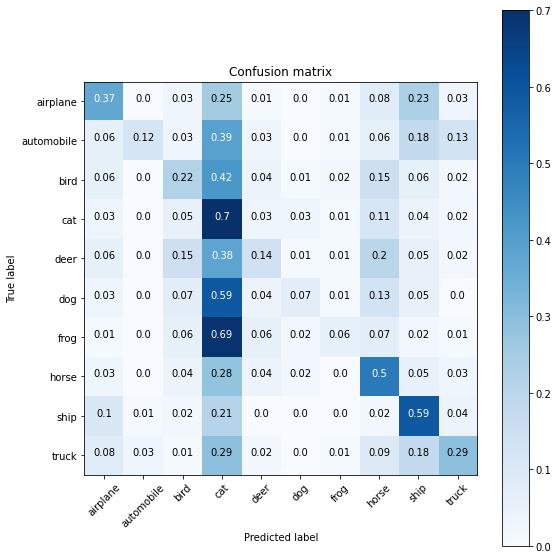

In [23]:
# to evaluate the model we compute the overall accuracy and 
# the class confusion matrix

accuracy = metrics.accuracy_score(test_labels, test_predictions)
print("Test accuracy")
print(accuracy)
print()

# we have implemented generating the confusion matrix in the utils already
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(test_labels,
                            test_predictions,
                            categories, ax)

## Logistic Regression with preset filters

Now, we will try to improve the model performance by presenting additional features to the model. For this, we can compute convolutional filters (see previous notebook) on the image and present the filter responses as (additional) features to the model.

Hopefully, these features provide additional context to the model that can improve its performance.

We will implement these preset filters using the transform mechanism we have implemented in the previous exercise.

In [24]:
# apply a list of filters as on the fly transformation. 
def apply_filters(image, target, filter_list, keep_image=False):    
    filtered = [image] if keep_image else [] 
    for filter_function in filter_list:
        filtered.append(filter_function(image))
    data = np.concatenate(filtered, axis=-1)
    return data, target

In [25]:
# build dataset with filter transformations

import skimage.filters as filters

filters = [filters.gaussian, filters.laplace]
filters = partial(apply_filters,
                  filter_list=filters,
                  keep_image=True)

trafos = [
    filters,
    utils.normalize,
    utils.to_channel_first,
    utils.to_tensor
]
trafos = partial(utils.compose, transforms=trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                           transform=trafos)

val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                         transform=trafos)

In [26]:
# make loaders for training and validation data
batch_size = 4
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=10)

In [27]:
# run training for the model with preset filters

n_pixels = 9 * 32 * 32  # number channels * number pixels
n_classes = 10    
model = LogisticRegressor(n_pixels, n_classes)
model.to(device)

optimizer = Adam(model.parameters(), lr=1.e-3)

# you can find the results of this training run in the tensorboard
# above as well, they will have the name 'log_reg_filters1' and
# will be differently colored compared to the first model
tb_logger = SummaryWriter('runs/log_reg_filters1')

n_epochs = 6
for epoch in trange(n_epochs):
    train(model, train_loader, loss_function, optimizer,
          device, epoch, tb_logger=tb_logger, log_image_interval=None)
    step = (epoch + 1) * len(train_loader)
    validate(model, val_loader, loss_function, device, step,
             tb_logger=tb_logger)

  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
 17%|█▋        | 1/6 [00:52<04:20, 52.16s/it]/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
 33%|███▎      | 2/6 [01:45<03:30, 52.69s/it]/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
 50%|█████     

In [ ]:
# evaluate the new model
test_dataset = utils.DatasetWithTransform(test_images, test_labels,
                                          transform=trafos)
test_loader = DataLoader(test_dataset, batch_size=25)

test_predictions, test_labels = validate(model, test_loader, loss_function,
                                         device, 0, tb_logger=None)
accuracy = metrics.accuracy_score(test_labels, test_predictions)
print("Test accuracy")
print(accuracy)
print()

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(test_labels,
                            test_predictions,
                            categories, ax)

## Tasks and Questions:

Tasks:
- The `learning_rate` (the parameter `lr` in Adam(model.parameters(), lr=1.e-3)) is a very important hyperparameter for training neural networks. Train the logistic regression model with filters using a few different learning rates and see how this changes the training curves and model performance. 

Questions:
- What accuracy do the different models reach?
- Which accuracy do you expect by guessing?
- Can you find any systematic errors from the confusion matrix?

Advanced:
- Train a model with more preset filters and compare the different models via tensorboard and on the test dataset.
- The filters we have used here can be expressed as convolutions.
    - Express the `gaussian` filter using [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and train a model using these filters.
    - Can you also explace the `laplace` filter?

In [28]:
# QUESTION: is "explace" a typo for "explain" here in this last question?